https://ai.plainenglish.io/haystack-the-new-llm-framework-that-is-shaking-its-competitors-1a083a153fd9

# Embedding

In [1]:
import urllib.request
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers import InMemoryEmbeddingRetriever
from haystack.components.converters import HTMLToDocument
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.embedders import OpenAIDocumentEmbedder, OpenAITextEmbedder
from haystack.components.writers import DocumentWriter
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

from dotenv import load_dotenv
load_dotenv(override=True)

True

In [2]:
urllib.request.urlretrieve("https://www.oreilly.com/openbook/freedom/ch01.html", r"test\free_as_in_freedom.html")

('test\\free_as_in_freedom.html', <http.client.HTTPMessage at 0x236992ab950>)

Componentes

In [3]:
document_store = InMemoryDocumentStore() # in memory or Vector Database
text_file_converter = HTMLToDocument() #will use the HTML file previously created
cleaner = DocumentCleaner() #will make text documents more readable
splitter = DocumentSplitter(split_by="sentence", split_length=5)
embedder = OpenAIDocumentEmbedder()
writer = DocumentWriter(document_store) #will writes a list of documents into a Document Store

Pipeline 

In [4]:
indexing_pipeline = Pipeline()
indexing_pipeline.add_component("converter", text_file_converter)
indexing_pipeline.add_component("cleaner", cleaner)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

Connectors

In [5]:
indexing_pipeline.connect("converter.documents", "cleaner.documents")
indexing_pipeline.connect("cleaner.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

🚅 Components
  - converter: HTMLToDocument
  - cleaner: DocumentCleaner
  - splitter: DocumentSplitter
  - embedder: OpenAIDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - converter.documents -> cleaner.documents (List[Document])
  - cleaner.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

Run

In [6]:
indexing_pipeline.run(data={"sources": ["free_as_in_freedom.html"]})

Could not read free_as_in_freedom.html. Skipping it. Error: [Errno 2] No such file or directory: 'free_as_in_freedom.html'
Calculating embeddings: 0it [00:00, ?it/s]


{'embedder': {'meta': {}}, 'writer': {'documents_written': 0}}

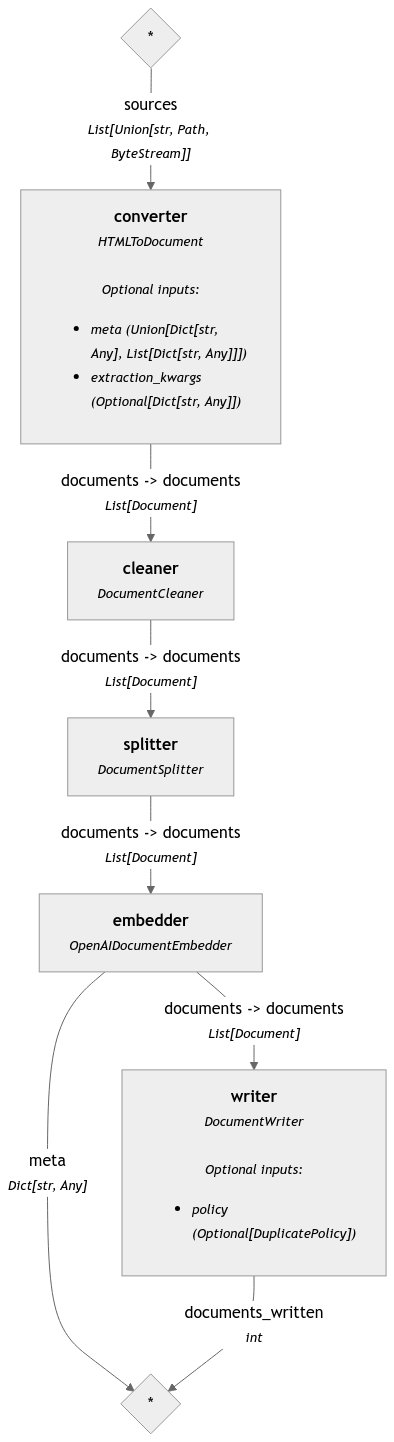

In [7]:
indexing_pipeline.show()

# RAG

In [8]:
template = """Given these documents, answer the question.
Documents:
{% for doc in documents %}
{{ doc.content }}
{% endfor %}
Question: {{query}}
Answer:"""
prompt_builder = PromptBuilder(template=template)

In [9]:
text_embedder = OpenAITextEmbedder()

In [10]:
retriever = InMemoryEmbeddingRetriever(document_store)

In [11]:
llm = OpenAIGenerator()

In [12]:
rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", llm)
rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever.documents", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

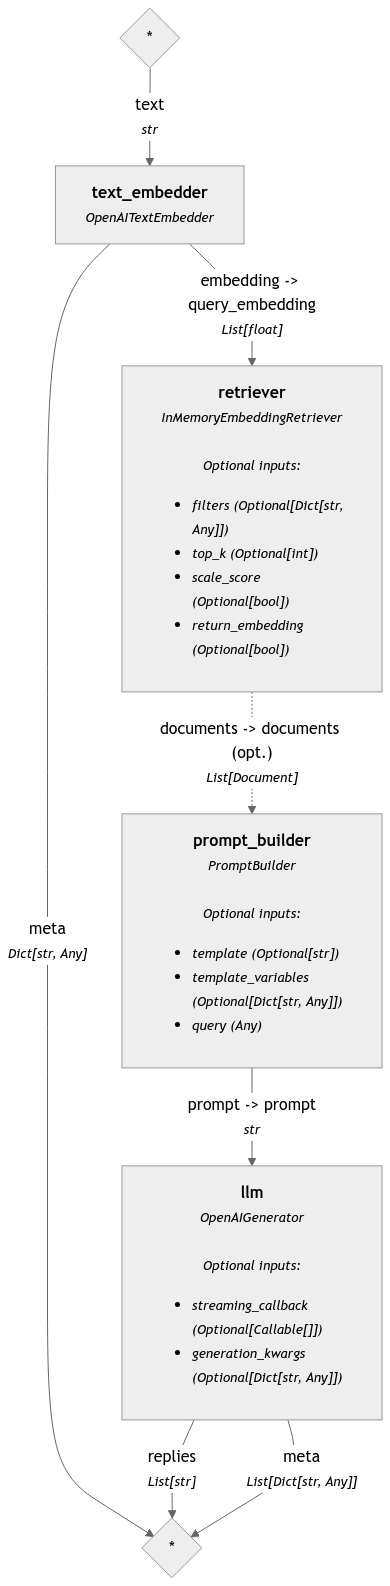

In [13]:
rag_pipeline.show()

In [14]:
query = " What is the profession of Richard M. Stallman and where does he works ?"
result = rag_pipeline.run(data={"prompt_builder": {"query":query}, "text_embedder": {"text": query}})
print(result["llm"]["replies"][0])

No Documents found with embeddings. Returning empty list. To generate embeddings, use a DocumentEmbedder.


Richard M. Stallman is a computer programmer and activist, known for his work in developing the GNU operating system and founding the Free Software Foundation. He works at the Massachusetts Institute of Technology (MIT).
